In [ ]:
!pip install torch-geometric

import os
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Dataset, Data
from sklearn.model_selection import KFold, train_test_split
from torch_geometric.utils import index_to_mask, mask_to_index
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 15.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=9097d3ce3662806fb9049df4e5a7be032453d771d53138dd982ab97a11e35b03
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd 
drive_path = '/content/drive/Shareddrives/CS523/lastFM-data/'
df_feat = pd.read_json(drive_path + 'new_feature_600_1028.json')   # load features
arr_feat = df_feat.T.values
df_edge = pd.read_csv(drive_path + 'lastfm_asia_edges.csv')   # load edge indices
arr_edge = df_edge.T.values
df_tar = pd.read_csv(drive_path + 'lastfm_asia_target.csv', index_col=0)   # load targets
arr_tar = df_tar.values

num_nodes = arr_feat.shape[0]
num_features = arr_feat.shape[1]
num_classes = len(df_tar.target.unique())
classes = df_tar.target.sort_values().unique()

In [ ]:
graph_metadata = {'data': arr_feat, 'edge_index': arr_edge, 'label': arr_tar}

In [ ]:
from torch_geometric.data import Data
edge_index = torch.tensor(arr_edge)
x = torch.tensor(arr_feat)
target = torch.tensor(arr_tar).squeeze().to(device)
data = Data(x=x, edge_index=edge_index)
data.to(device)

Data(x=[7624, 600], edge_index=[2, 27806])

In [ ]:
def graphdataset_split(dataset, n_fold):

    X = np.arange(num_nodes)
    splits = KFold(n_fold, shuffle=True, random_state=42)   # fix the seed to make the split reproducible
    splits.split(X)
    
    train_sets = []
    valid_sets = []
    test_sets = []

    for train_index, test_index in splits.split(X):
        train_index, valid_index = train_test_split(train_index, test_size=0.1)
        train_sets.append(list(train_index))
        valid_sets.append(list(valid_index))
        test_sets.append(list(test_index))

    return train_sets, valid_sets, test_sets

In [ ]:
n_fold = 5
train_sets, valid_sets, test_sets = graphdataset_split(data, n_fold)

train_masks = []
valid_masks = []
test_masks = []

for i in range(n_fold):
    
    train_mask = index_to_mask(torch.tensor(train_sets[i]), size=num_nodes).to(device)
    valid_mask = index_to_mask(torch.tensor(valid_sets[i]), size=num_nodes).to(device)
    test_mask = index_to_mask(torch.tensor(test_sets[i]), size=num_nodes).to(device)
       
    
    train_masks.append(train_mask)
    valid_masks.append(valid_mask)
    test_masks.append(test_mask)


In [ ]:
class GCN(torch.nn.Module):
    
    def __init__(self, hidden_channels1, hidden_channels2, hidden_channels3):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, hidden_channels3)
        self.linear1 = torch.nn.Linear(hidden_channels3, hidden_channels3)
        self.linear2 = torch.nn.Linear(hidden_channels3, num_features)

    def forward(self, x, edge_index, train_mask):

        # out = torch.zeros_like(x)
        train_nodes = mask_to_index(train_mask)
        untrain_nodes = mask_to_index(~train_mask)
        x_masked = x.clone()
        x_masked = torch.where(x_masked==1, 1., -1.)   # change binary values to ±1
        x_masked[untrain_nodes] = 0   # mask out un-training node features

        out = self.conv1(x_masked, edge_index)
        out = out.relu()
        # out = F.dropout(out, p=0.5)
        out = self.conv2(out, edge_index)
        out = out.relu()
        # out = F.dropout(out, p=0.5)
        out = self.conv3(out, edge_index)
        out = out.relu()
        out = F.dropout(out, p=0.5)
        out = self.linear1(out)
        out = out.relu()
        out = F.dropout(out, p=0.5)
        out = self.linear2(out)
        out = out.sigmoid()
        return out

In [ ]:
from math import sqrt
from typing import Optional, Tuple, Union

import torch
from torch import Tensor
from torch.nn.parameter import Parameter

from torch_geometric.explain import ExplainerConfig, Explanation, ModelConfig
from torch_geometric.explain.algorithm import ExplainerAlgorithm
from torch_geometric.explain.algorithm.utils import clear_masks, set_masks
from torch_geometric.explain.config import MaskType, ModelMode, ModelTaskLevel


class GNNExplainer(ExplainerAlgorithm):
    coeffs = {
        'edge_size': 0.005,
        'edge_reduction': 'sum',
        'node_feat_size': 1.0,
        'node_feat_reduction': 'mean',
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
        'EPS': 1e-15,
    }

    def __init__(self, epochs: int = 100, lr: float = 0.01, **kwargs):
        super().__init__()
        self.epochs = epochs
        self.lr = lr
        self.coeffs.update(kwargs)

        self.node_mask = self.hard_node_mask = None
        self.edge_mask = self.hard_edge_mask = None


    def _post_process_mask(self, mask: Tensor, hard_mask: Optional[Tensor], apply_sigmoid: bool = False) -> Tensor:
        if hard_mask is not None and not isinstance(hard_mask, bool) and mask.size(0) == hard_mask.size(0):
            mask = mask[hard_mask]

        if apply_sigmoid:
            mask = mask.sigmoid()

        return mask


    def forward(
        self,
        model: torch.nn.Module,
        x: Tensor,
        edge_index: Tensor,
        *,
        target: Tensor,
        index: Optional[Union[int, Tensor]] = None,
        **kwargs,
    ) -> Explanation:
        if isinstance(x, dict) or isinstance(edge_index, dict):
            raise ValueError(f"Heterogeneous graphs not yet supported in "
                             f"'{self.__class__.__name__}'")

        self._train(model, x, edge_index, target=target, index=index, **kwargs)

        node_mask = self._post_process_mask(
            self.node_mask,
            self.hard_node_mask,
            apply_sigmoid=True,
        )
        edge_mask = self._post_process_mask(
            self.edge_mask,
            self.hard_edge_mask,
            apply_sigmoid=True,
        )

        self._clean_model(model)

        return Explanation(node_mask=node_mask, edge_mask=edge_mask)

    def supports(self) -> bool:
        return True

    def _train(
        self,
        model: torch.nn.Module,
        x: Tensor,
        edge_index: Tensor,
        *,
        target: Tensor,
        index: Optional[Union[int, Tensor]] = None,
        **kwargs,
    ):
        self._initialize_masks(x, edge_index)

        parameters = []
        if self.node_mask is not None:
            parameters.append(self.node_mask)
        if self.edge_mask is not None:
            set_masks(model, self.edge_mask, edge_index, apply_sigmoid=True)
            parameters.append(self.edge_mask)

        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        for i in range(self.epochs):
            optimizer.zero_grad()

            h = x if self.node_mask is None else x * self.node_mask.sigmoid()
            y_hat, y = model(h, edge_index, **kwargs), target

            if index is not None:
                y_hat, y = y_hat[index], y[index]

            loss = self._loss(y_hat, y)
            loss.backward()
            optimizer.step()

            # In the first iteration, we collect the nodes and edges that are
            # involved in making the prediction. These are all the nodes and
            # edges with gradient != 0 (without regularization applied).
            if i == 0:
                if self.node_mask is not None and self.hard_node_mask is None:
                    self.hard_node_mask = self.node_mask.grad != 0.0
                if self.edge_mask is not None and self.hard_edge_mask is None:
                    self.hard_edge_mask = self.edge_mask.grad != 0.0
    
    def _initialize_masks(self, x: Tensor, edge_index: Tensor):
        node_mask_type = self.explainer_config.node_mask_type
        edge_mask_type = self.explainer_config.edge_mask_type

        device = x.device
        (N, F), E = x.size(), edge_index.size(1)

        std = 0.1
        if node_mask_type is None:
            self.node_mask = None
        elif node_mask_type == MaskType.object:
            self.node_mask = Parameter(torch.randn(N, 1, device=device) * std)
        elif node_mask_type == MaskType.attributes:
            self.node_mask = Parameter(torch.randn(N, F, device=device) * std)
        elif node_mask_type == MaskType.common_attributes:
            self.node_mask = Parameter(torch.randn(1, F, device=device) * std)
        else:
            assert False

        if edge_mask_type is None:
            self.edge_mask = None
        elif edge_mask_type == MaskType.object:
            std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
            self.edge_mask = Parameter(torch.randn(E, device=device) * std)
        else:
            assert False

    def _loss(self, y_hat: Tensor, y: Tensor) -> Tensor:
        if self.model_config.mode == ModelMode.binary_classification:
            loss = self._loss_binary_classification(y_hat, y)
        elif self.model_config.mode == ModelMode.multiclass_classification:
            loss = self._loss_multiclass_classification(y_hat, y)
        elif self.model_config.mode == ModelMode.regression:
            loss = self._loss_regression(y_hat, y)
        else:
            assert False

        if self.hard_edge_mask is not None:
            assert self.edge_mask is not None
            m = self.edge_mask[self.hard_edge_mask].sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
            ent = -m * torch.log(m + self.coeffs['EPS']) - (
                1 - m) * torch.log(1 - m + self.coeffs['EPS'])
            loss = loss + self.coeffs['edge_ent'] * ent.mean()

        if self.hard_node_mask is not None:
            assert self.node_mask is not None
            m = self.node_mask[self.hard_node_mask].sigmoid()
            node_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
            loss = loss + self.coeffs['node_feat_size'] * node_reduce(m)
            ent = -m * torch.log(m + self.coeffs['EPS']) - (
                1 - m) * torch.log(1 - m + self.coeffs['EPS'])
            loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss

    def _clean_model(self, model):
        clear_masks(model)
        self.node_mask = self.hard_node_mask = None
        self.edge_mask = self.hard_edge_mask = None



class GNNExplainer_:
    r"""Deprecated version for :class:`GNNExplainer`."""

    coeffs = GNNExplainer.coeffs

    conversion_node_mask_type = {
        'feature': 'common_attributes',
        'individual_feature': 'attributes',
        'scalar': 'object',
    }

    conversion_return_type = {
        'log_prob': 'log_probs',
        'prob': 'probs',
        'raw': 'raw',
        'regression': 'raw',
    }

    def __init__(
        self,
        model: torch.nn.Module,
        epochs: int = 100,
        lr: float = 0.01,
        return_type: str = 'log_prob',
        feat_mask_type: str = 'feature',
        allow_edge_mask: bool = True,
        **kwargs,
    ):
        assert feat_mask_type in ['feature', 'individual_feature', 'scalar']

        explainer_config = ExplainerConfig(
            explanation_type='model',
            node_mask_type=self.conversion_node_mask_type[feat_mask_type],
            edge_mask_type=MaskType.object if allow_edge_mask else None,
        )
        model_config = ModelConfig(
            mode='regression'
            if return_type == 'regression' else 'multiclass_classification',
            task_level=ModelTaskLevel.node,
            return_type=self.conversion_return_type[return_type],
        )

        self.model = model
        self._explainer = GNNExplainer(epochs=epochs, lr=lr, **kwargs)
        self._explainer.connect(explainer_config, model_config)

    @torch.no_grad()
    def get_initial_prediction(self, *args, **kwargs) -> Tensor:

        training = self.model.training
        self.model.eval()

        out = self.model(*args, **kwargs)
        if (self._explainer.model_config.mode ==
                ModelMode.multiclass_classification):
            out = out.argmax(dim=-1)

        self.model.train(training)

        return out

    def explain_graph(
        self,
        x: Tensor,
        edge_index: Tensor,
        **kwargs,
    ) -> Tuple[Tensor, Tensor]:
        self._explainer.model_config.task_level = ModelTaskLevel.graph

        explanation = self._explainer(
            self.model,
            x,
            edge_index,
            target=self.get_initial_prediction(x, edge_index, **kwargs),
            **kwargs,
        )
        return self._convert_output(explanation, edge_index)

    def explain_node(
        self,
        node_idx: int,
        x: Tensor,
        edge_index: Tensor,
        **kwargs,
    ) -> Tuple[Tensor, Tensor]:
        self._explainer.model_config.task_level = ModelTaskLevel.node
        explanation = self._explainer(
            self.model,
            x,
            edge_index,
            target=self.get_initial_prediction(x, edge_index, **kwargs),
            index=node_idx,
            **kwargs,
        )
        return self._convert_output(explanation, edge_index, index=node_idx,
                                    x=x)

    def _convert_output(self, explanation, edge_index, index=None, x=None):
        node_mask = explanation.get('node_mask')
        edge_mask = explanation.get('edge_mask')

        if node_mask is not None:
            node_mask_type = self._explainer.explainer_config.node_mask_type
            if node_mask_type in {MaskType.object, MaskType.common_attributes}:
                node_mask = node_mask.view(-1)

        if edge_mask is None:
            if index is not None:
                _, edge_mask = self._explainer._get_hard_masks(
                    self.model, index, edge_index, num_nodes=x.size(0))
                edge_mask = edge_mask.to(x.dtype)
            else:
                edge_mask = torch.ones(edge_index.shape[1],
                                       device=edge_index.device)

        return node_mask, edge_mask


Feature importance for one user

In [ ]:
#test sets:  0,1,2,3,4
#model fold: 1,2,3,4,5
node_idx = 2055
for i in range(len(test_sets)):
  if node_idx in test_sets[i]:
    print(i)

4


In [ ]:
idx = 4

In [ ]:
model = torch.load(f'/content/drive/Shareddrives/CS523/Notebooks/model/GCN_600/fold_'+str(idx+1)+'.pt')

In [ ]:
#from torch_geometric.explain import ExplainerConfig, ModelConfig, GNNExplainer

from torch_geometric.explain import ExplainerConfig, ModelConfig
# Define explainer and model configurations
explainer_config = ExplainerConfig(explanation_type='model',
                                    node_mask_type='attributes',
                                    edge_mask_type='object')
model_config = ModelConfig(mode='multiclass_classification',
                            task_level='node',
                            return_type='log_probs')

# Instantiate the GNNExplainer with the explainer and model configurations
explainer = GNNExplainer(epochs=200, lr=0.01)
explainer.connect(explainer_config, model_config)

# Use the GNNExplainer to explain your GNN model
explanation = explainer(x=data.x, edge_index = data.edge_index, model=model, target=target, train_mask=train_masks[idx])
node_mask, edge_mask = explanation.node_mask, explanation.edge_mask

In [ ]:
node_mask

tensor([[0.1805, 0.1591, 0.1595,  ..., 0.1910, 0.1860, 0.1644],
        [0.1898, 0.1600, 0.1882,  ..., 0.1856, 0.1708, 0.1773],
        [0.1855, 0.1834, 0.1883,  ..., 0.1919, 0.1861, 0.1815],
        ...,
        [0.1724, 0.1730, 0.1769,  ..., 0.1797, 0.1525, 0.1834],
        [0.1693, 0.1597, 0.1649,  ..., 0.1713, 0.1717, 0.2061],
        [0.1821, 0.1883, 0.1579,  ..., 0.1710, 0.1551, 0.1792]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
edge_mask

tensor([0.1492, 0.1480, 0.1508,  ..., 0.1479, 0.1474, 0.1467], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [ ]:
explainer = GNNExplainer_(model)
import time 
start_time = time.time()
node_feat_mask, edge_feat_mask = explainer.explain_node(node_idx, data.x, data.edge_index, train_mask=train_masks[idx])
print('time:', time.time() - start_time)

time: 223.3418083190918


In [ ]:
len(node_feat_mask)

600

Feature importance for all users

In [ ]:
import time
masks = [0, 1, 2, 3, 4]
folds = [1, 2, 3, 4, 5]

mask = 3
fold = 4

model = torch.load(f'/content/drive/Shareddrives/CS523/Notebooks/model/GCN_600/fold_'+str(fold)+'.pt')
explainer = GNNExplainer_(model)

print(len(test_sets[mask]))

start_time = time.time()
result = []
for node_idex in test_sets[mask]:
  node_feat_mask, edge_feat_mask = explainer.explain_node(node_idex, data.x, data.edge_index, train_mask=train_masks[mask])
  node_feat = node_feat_mask.cpu().detach().numpy()
  result.append(node_feat)
print('time:', time.time() - start_time)

result_df = pd.DataFrame(result)

output_path = '/content/drive/Shareddrives/CS523/Notebooks/GNNExplainer_result/'
result_df.to_csv(output_path+"featureImportance_fold"+str(fold)+".csv")

1525


KeyboardInterrupt: ignored

In [ ]:
print(result_df.shape)
result_df.head(5)

(1525, 600)


,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.274701,0.317818,0.261583,0.285748,0.274495,0.279216,0.241256,0.259283,0.276311,0.264026,...,0.275255,0.232471,0.276710,0.289487,0.255520,0.298488,0.233280,0.277804,0.260188,0.275731
1,0.309111,0.273537,0.240492,0.316713,0.291682,0.287057,0.270703,0.292174,0.276149,0.265062,...,0.286211,0.265152,0.284212,0.270116,0.256661,0.282911,0.305394,0.268299,0.255205,0.284040
2,0.302305,0.287324,0.239241,0.254872,0.254187,0.256204,0.274232,0.252790,0.287870,0.248802,...,0.272800,0.263747,0.260996,0.260558,0.272834,0.255038,0.260801,0.271432,0.306531,0.281161
3,0.265904,0.259275,0.266183,0.258819,0.289362,0.264960,0.249250,0.294502,0.292266,0.271581,...,0.274018,0.293007,0.261998,0.287555,0.266484,0.248146,0.287893,0.289289,0.270113,0.274984
4,0.250708,0.298984,0.237700,0.295062,0.299157,0.265572,0.276254,0.297056,0.254218,0.258217,...,0.233309,0.284631,0.263742,0.273580,0.267542,0.266144,0.294117,0.249235,0.273534,0.255268


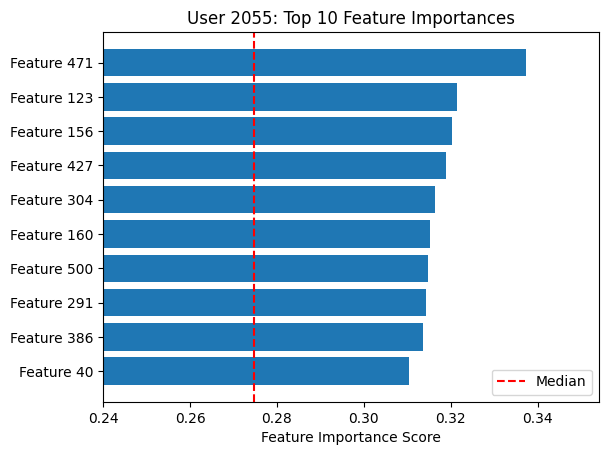

In [ ]:
from matplotlib.ticker import MultipleLocator
import numpy as np
import matplotlib.pyplot as plt

output_path = '/content/drive/Shareddrives/CS523/Notebooks/GNNExplainer_result/'

def visualize_feature_importance(node_feat_mask, feat_labels=None, top_k=10):
    # Ensure node_feat_mask is a NumPy array
    #if isinstance(node_feat_mask, torch.Tensor):
        #node_feat_mask = node_feat_mask.cpu().numpy()

    # Calculate the sum along the first axis
    #feat_importance = np.sum(node_feat_mask, axis=0)
    feat_importance = node_feat_mask.cpu().detach().numpy() 

    # Get the top k indices
    top_k_indices = np.argsort(feat_importance)[-top_k:]

    # Get the top k feature importances
    top_k_feat_importance = feat_importance[top_k_indices]

    if feat_labels is None:
        feat_labels = [f"Feature {i}" for i in range(len(node_feat_mask))]

    top_k_feat_labels = [feat_labels[i] for i in top_k_indices]

    # Compute the median of node_feat_mask
    median_importance = np.median(feat_importance)

    # Plot the feature importances
    plt.barh(range(top_k), top_k_feat_importance, align='center')
    #x_major_locator = MultipleLocator(0.01)
    #ax = plt.gca()
    #ax.xaxis.set_major_locator(x_major_locator)
    plt.xlim(left=0.24)
    plt.yticks(range(top_k), top_k_feat_labels)
    plt.axvline(x=median_importance, color='r', linestyle='--', label='Median')
    plt.xlabel('Feature Importance Score')
    plt.title('User {}: Top {} Feature Importances'.format(node_idx, top_k))
    plt.legend()
    plt.savefig(output_path+str(node_idx)+"_top10_features.png", bbox_inches='tight')
    plt.show()

# Example usage:
#node_feat_mask = explanation.node_mask.detach().numpy()
visualize_feature_importance(node_feat_mask, feat_labels=None, top_k=10)


In [5]:
import pandas as pd 

output_path = '/content/drive/Shareddrives/CS523/Notebooks/GNNExplainer_result/'
fold1 = pd.read_csv(output_path+'featureImportance_fold1.csv', index_col=0)
fold2 = pd.read_csv(output_path+'featureImportance_fold2.csv', index_col=0)
fold3 = pd.read_csv(output_path+'featureImportance_fold3.csv', index_col=0)
fold4 = pd.read_csv(output_path+'featureImportance_fold4.csv', index_col=0)
fold5 = pd.read_csv(output_path+'featureImportance_fold5.csv', index_col=0)

In [6]:
allfold = pd.concat([fold1, fold2, fold3, fold4, fold5])
allfold = allfold.reset_index(drop=True)
print(allfold.shape)
allfold.head(4)

(7624, 600)


,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.280347,0.272379,0.310527,0.269846,0.291888,0.293100,0.266498,0.270707,0.278248,0.299150,...,0.267470,0.285639,0.274786,0.276107,0.298394,0.283510,0.257193,0.246657,0.229334,0.278404
1,0.293343,0.275425,0.276671,0.250055,0.290354,0.281121,0.277211,0.291048,0.264375,0.255416,...,0.282930,0.296416,0.253297,0.269560,0.294422,0.265562,0.279747,0.266947,0.303615,0.257330
2,0.280681,0.258140,0.270783,0.258186,0.276498,0.284120,0.287657,0.286125,0.299504,0.307884,...,0.290673,0.284781,0.261821,0.270391,0.236082,0.264112,0.274914,0.289139,0.284300,0.280236
3,0.274094,0.298062,0.257053,0.248094,0.287244,0.259192,0.276589,0.277498,0.293077,0.281386,...,0.303737,0.263862,0.280309,0.257829,0.268917,0.276483,0.259211,0.271791,0.269310,0.254164


In [7]:
#all_features = ((allfold.sum(axis=0)/7624).to_numpy() - 0.27)*100
all_features = (allfold.sum(axis=0)/7624).to_numpy()

In [9]:
import numpy as np
all_features_norm = (all_features-np.min(all_features))/(np.max(all_features)-np.min(all_features))

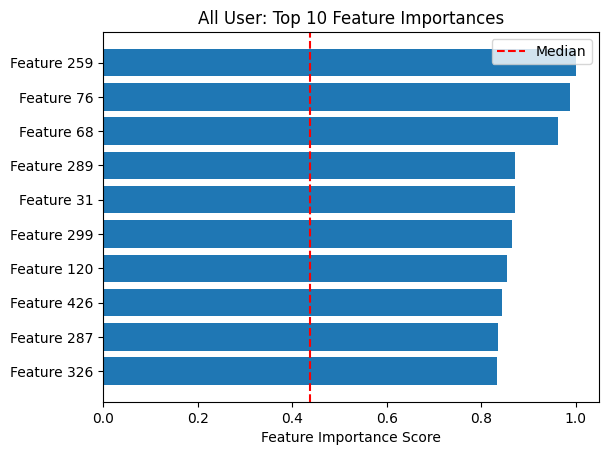

In [16]:
import numpy as np
import matplotlib.pyplot as plt
# Get the top k indices
top_k_indices = np.argsort(all_features_norm)[-10:]

# Get the top k feature importances
top_k_feat_importance = all_features_norm[top_k_indices]

feat_labels = [f"Feature {i}" for i in range(600)]

top_k_feat_labels = [feat_labels[i] for i in top_k_indices]

# Compute the median of node_feat_mask
median_importance = np.median(all_features_norm)

# Plot the feature importances
plt.barh(range(10), top_k_feat_importance, align='center')
#x_major_locator = MultipleLocator(0.01)
#ax = plt.gca()
#ax.xaxis.set_major_locator(x_major_locator)

#plt.xlim(left=0.274, right=0.276)
#plt.xlim(left=0.4)
plt.yticks(range(10), top_k_feat_labels)
plt.axvline(x=median_importance, color='r', linestyle='--', label='Median')
plt.xlabel('Feature Importance Score')
plt.title('All User: Top {} Feature Importances'.format(10))
plt.legend()
plt.savefig(output_path+"AllUser_top10_features.png", bbox_inches='tight')
plt.show()


In [ ]:
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt

# Convert edge_index to networkx graph
G = torch_geometric.utils.to_networkx(data)

# Visualize the graph with node and edge importance
pos = nx.spring_layout(G)

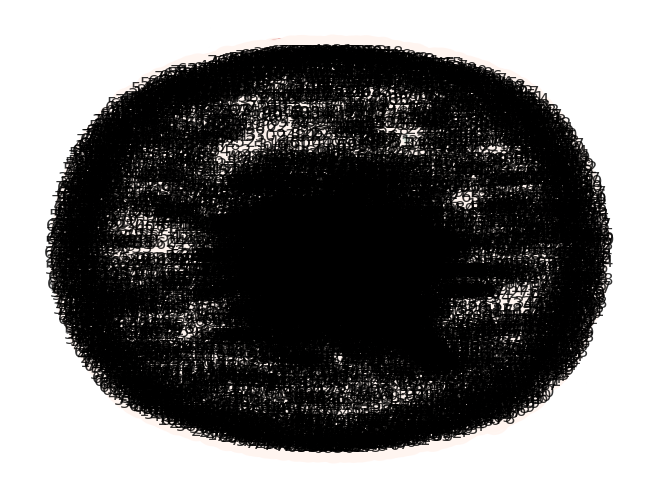

In [ ]:
node_colors = [0.0] * data.num_nodes
#node_colors[node_idx:node_idx+len(node_feat_mask)] = node_feat_mask.squeeze().tolist()
# Normalize edge_mask values for better visualization
edge_colors = (edge_mask / edge_mask.max()).tolist()
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.Reds, edge_color=edge_colors, width=2.0, with_labels=True, node_size=500, alpha=0.8)
plt.show()

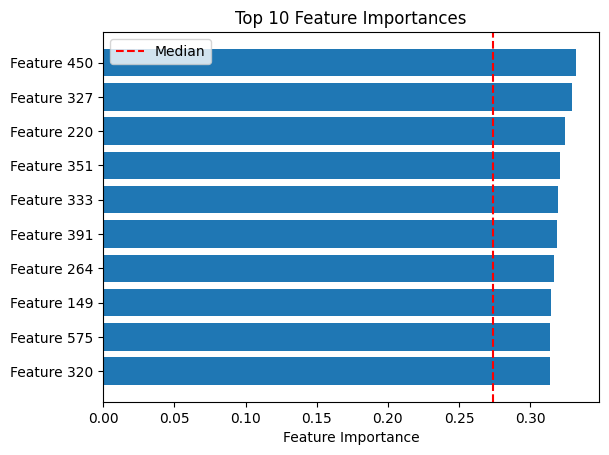

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_feature_importance(node_feat_mask, feat_labels=None, top_k=10):
    # Ensure node_feat_mask is a NumPy array
    #if isinstance(node_feat_mask, torch.Tensor):
        #node_feat_mask = node_feat_mask.cpu().numpy()

    # Calculate the sum along the first axis
    #feat_importance = np.sum(node_feat_mask, axis=0)
    feat_importance = node_feat_mask.cpu().detach().numpy() 

    # Get the top k indices
    top_k_indices = np.argsort(feat_importance)[-top_k:]

    # Get the top k feature importances
    top_k_feat_importance = feat_importance[top_k_indices]

    if feat_labels is None:
        feat_labels = [f"Feature {i}" for i in range(len(node_feat_mask))]

    top_k_feat_labels = [feat_labels[i] for i in top_k_indices]

    # Compute the median of node_feat_mask
    median_importance = np.median(feat_importance)

    # Plot the feature importances
    plt.barh(range(top_k), top_k_feat_importance, align='center')
    plt.yticks(range(top_k), top_k_feat_labels)
    plt.axvline(x=median_importance, color='r', linestyle='--', label='Median')
    plt.xlabel('Feature Importance')
    plt.title('Top {} Feature Importances'.format(top_k))
    plt.legend()
    plt.show()

# Example usage:
#node_feat_mask = explanation.node_mask.detach().numpy()
visualize_feature_importance(node_feat_mask, feat_labels=None, top_k=10)
